Number of records in the file: 19019
Number of fields in the file: 11
    28.7967   16.0021  2.6449  0.3918  0.1982   27.7004   22.011  -8.2027  \
0   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238  -9.9574   
1  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580 -45.2160   
2   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633  -7.1513   
3   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525  21.8393   
4   51.6240   21.1502  2.9085  0.2420  0.1340   50.8761  43.1887   9.8145   
5   48.2468   17.3565  3.0332  0.2529  0.1515    8.5730  38.0957  10.5868   
6   26.7897   13.7595  2.5521  0.4236  0.2174   29.6339  20.4560  -2.9292   
7   96.2327   46.5165  4.1540  0.0779  0.0390  110.3550  85.0486  43.1844   
8   46.7619   15.1993  2.5786  0.3377  0.1913   24.7548  43.8771  -6.6812   
9   62.7766   29.9104  3.3331  0.2475  0.1261  -33.9065  57.5848  23.7710   

    40.092  81.8828  g  
0   6.3609  205.261  g  
1  76.9600  256.788  g  
2  10.4

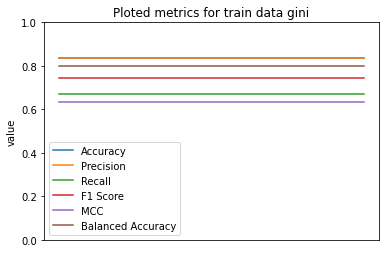

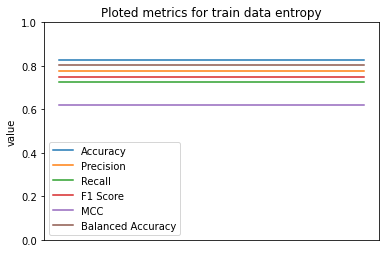

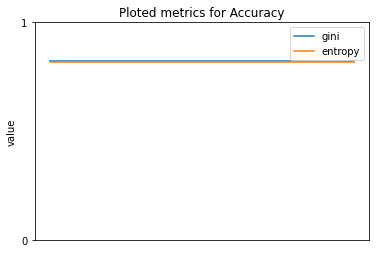

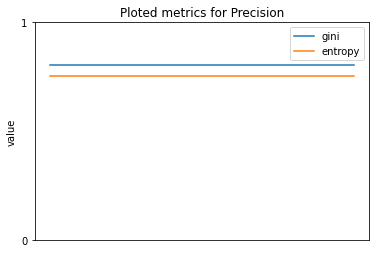

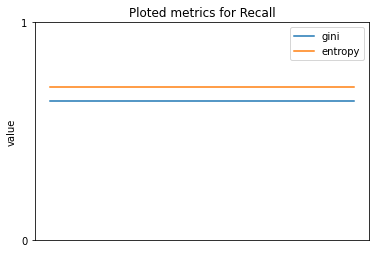

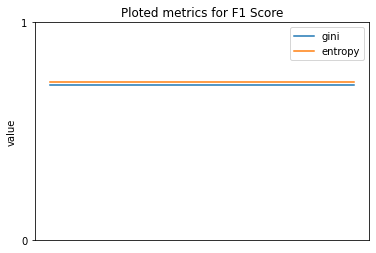

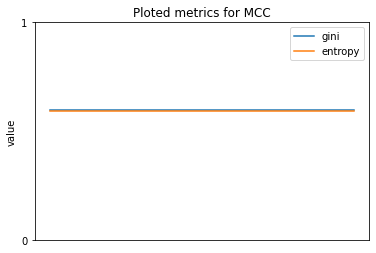

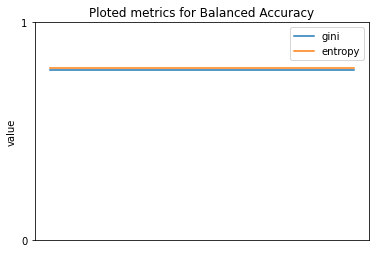

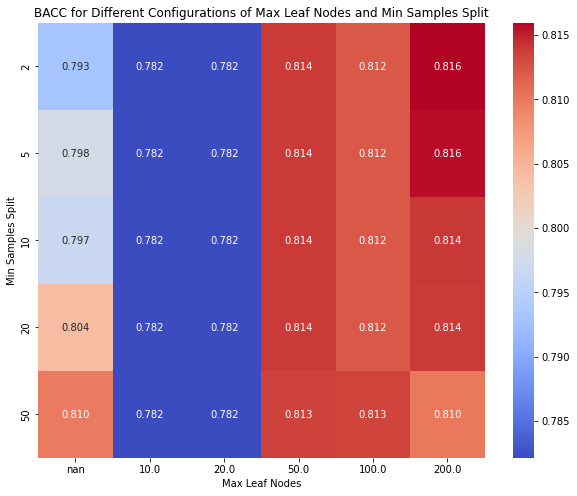

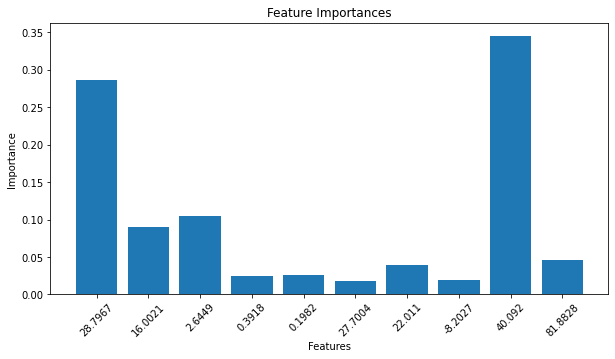

In [3]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, balanced_accuracy_score
)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import seaborn as sns

# 1
df = pd.read_csv('dataset3.csv')

# 2
fieldsnum = len(df.columns)
recordnum = len(df)
print(f"Number of records in the file: {recordnum}")
print(f"Number of fields in the file: {fieldsnum}")

# 3
print(df.head(10))

# 4
X = df.iloc[:, :-1]  
y = df.iloc[:, -1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True)

# 5
clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=5)

clf_entropy.fit(X_train, y_train)
clf_gini.fit(X_train, y_train)

# 6
img = export_graphviz(
  clf_entropy,
  feature_names=X_train.columns,
  class_names=list(map(str, y_train.unique())),
  rounded=True,
  filled=True
)
graph = graphviz.Source(img)
graph.view(directory='entropy')

img = export_graphviz(
  clf_gini,
  feature_names=X_train.columns,
  class_names=list(map(str, y_train.unique())),
  rounded=True,
  filled=True
)
graph = graphviz.Source(img)
graph.view(directory='gini')

# 7
def metrics(trues, pred_model):
  metrics_results = {}
  metrics_results['Accuracy'] = accuracy_score(trues, pred_model)
  metrics_results['Precision'] = precision_score(trues, pred_model, zero_division=0, pos_label='h')
  metrics_results['Recall'] = recall_score(trues, pred_model, pos_label='h')
  metrics_results['F1 Score'] = f1_score(trues, pred_model, pos_label='h')
  metrics_results['MCC'] = matthews_corrcoef(trues, pred_model)
  metrics_results['Balanced Accuracy'] = balanced_accuracy_score(trues, pred_model)
  return metrics_results

entropy_pred_train = clf_entropy.predict(X_train)
entropy_pred_test = clf_entropy.predict(X_test)

gini_pred_train = clf_gini.predict(X_train)
gini_pred_test = clf_gini.predict(X_test)

print('Entropy - train')
print(metrics(y_train, entropy_pred_train))
print('Gini - train')
print(metrics(y_train, gini_pred_train))
print('Entropy - test')
print(metrics(y_test, entropy_pred_test))
print('Gini - test')
print(metrics(y_test, gini_pred_test))

metrics_gini = metrics(y_train, gini_pred_train)
metrics_entropy = metrics(y_train, entropy_pred_train)

for n, m in [('gini', metrics_gini), ('entropy', metrics_entropy)]:
  for i in m:
    plt.plot([0, 1], [m[i]]*2, label=i)

  plt.title(f'Ploted metrics for train data {n}')
  plt.xticks([])
  plt.ylim(0, 1)
  plt.ylabel('value')
  plt.legend()
  plt.show()

metrics_gini = metrics(y_test, gini_pred_test)
metrics_entropy = metrics(y_test, entropy_pred_test)

for metrics in metrics_gini:
  plt.plot([0, 1], [metrics_gini[metrics]] * 2, label='gini')
  plt.plot([0, 1], [metrics_entropy[metrics]] * 2, label='entropy')

  plt.title(f'Ploted metrics for {metrics}')
  plt.xticks([])
  plt.yticks([0, 1])
  plt.ylabel('value')
  plt.legend()
  plt.show()

# 8

max_leaf_nodes_range = [10, 20, 50, 100, 200, None]
min_samples_split_range = [2, 5, 10, 20, 50]

results = []

for max_leaf_nodes in max_leaf_nodes_range:
    for min_samples_split in min_samples_split_range:
        clf = DecisionTreeClassifier(criterion='gini', max_leaf_nodes=max_leaf_nodes, min_samples_split=min_samples_split)
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        baccuracy = balanced_accuracy_score(y_test, y_pred_test)
        results.append((max_leaf_nodes, min_samples_split, baccuracy))

results_df = pd.DataFrame(results, columns=['Max Leaf Nodes', 'Min Samples Split', 'BACC'])

pivot_table = results_df.pivot(index='Min Samples Split', columns='Max Leaf Nodes', values='BACC')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="coolwarm")
plt.title('BACC for Different Configurations of Max Leaf Nodes and Min Samples Split')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Min Samples Split')
plt.show()

# 9
feature_importances = clf.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 5))
plt.bar(features, feature_importances)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()